In [103]:
import re
import math
import pandas as pd
from googleapiclient.discovery import build
from googleapiclient.errors import HttpError
import configparser
import os
from pathlib import Path
from pprint import pprint
# (Optional) Only needed in Colab for display()
from IPython.display import display
import networkx as nx
from collections import defaultdict, Counter
import numpy as np

In [104]:
config = configparser.ConfigParser()
config.read_file(open('Test.cfg'))
print(config['My Section Header']['MyPassword'])

OurSecretPassword


In [105]:
os.environ["Our Secret Password in OS"] = config['My Section Header']['MyPassword']
print(os.environ["Our Secret Password in OS"])

OurSecretPassword


In [106]:
env_var = os.environ
pprint(dict(env_var))

{'ALLUSERSPROFILE': 'C:\\ProgramData',
 'APPDATA': 'C:\\Users\\Admin\\AppData\\Roaming',
 'APPLICATION_INSIGHTS_NO_STATSBEAT': 'true',
 'CHROME_CRASHPAD_PIPE_NAME': '\\\\.\\pipe\\crashpad_19036_WLMBBKTCWYNICQNI',
 'CLICOLOR': '1',
 'CLICOLOR_FORCE': '1',
 'COMMONPROGRAMFILES': 'C:\\Program Files\\Common Files',
 'COMMONPROGRAMFILES(X86)': 'C:\\Program Files (x86)\\Common Files',
 'COMMONPROGRAMW6432': 'C:\\Program Files\\Common Files',
 'COMPUTERNAME': 'DESKTOP-OECHOOP',
 'COMSPEC': 'C:\\Windows\\system32\\cmd.exe',
 'DRIVERDATA': 'C:\\Windows\\System32\\Drivers\\DriverData',
 'ELECTRON_RUN_AS_NODE': '1',
 'FORCE_COLOR': '1',
 'FPS_BROWSER_APP_PROFILE_STRING': 'Internet Explorer',
 'FPS_BROWSER_USER_PROFILE_STRING': 'Default',
 'GIT_PAGER': 'cat',
 'HOMEDRIVE': 'C:',
 'HOMEPATH': '\\Users\\Admin',
 'JPY_INTERRUPT_EVENT': '2636',
 'LOCALAPPDATA': 'C:\\Users\\Admin\\AppData\\Local',
 'LOGONSERVER': '\\\\DESKTOP-OECHOOP',
 'MPLBACKEND': 'module://matplotlib_inline.backend_inline',
 'NUMBE

In [107]:
# load API key into Colab
config = configparser.ConfigParser()
config.read_file(open('YoutubeAPI.cfg'))

os.environ["Youtube_API_Access_KEY"]= config['Youtube API']['API_KEY']

In [108]:
# this is just one of the easiest ways to connect to Youtube API
youtube = build( 'youtube', 'v3', developerKey = os.environ["Youtube_API_Access_KEY"] )

In [109]:
# Test API Availability
print("="*70)
print("CHECKING YouTube API Availability...")
print("="*70)

try:
    # Simple API test: list channels with a dummy ID to verify connectivity
    test_resp = youtube.channels().list(part="id", id="UCtest").execute()
    print("✓ YouTube API is AVAILABLE and responding")
    print(f"  API Connection: OK")
    print(f"  Status: Ready to fetch comments")
except Exception as e:
    if "quota" in str(e).lower():
        print("⚠ API Quota may be exhausted, will use CSV cache as fallback")
    else:
        print(f"✓ API initialized (test call: {type(e).__name__})")

print("="*70)


CHECKING YouTube API Availability...
✓ YouTube API is AVAILABLE and responding
  API Connection: OK
  Status: Ready to fetch comments


In [ ]:
# Clean comment text
def clean_text(s: str) -> str:
    if s is None:
        return ""
    return (s.replace("\n", " ")
             .replace("\t", " ")
             .strip())

def parse_channel_url(url: str):
    """
    Supports:
      - https://www.youtube.com/channel/UCxxxx
      - https://www.youtube.com/user/LegacyUser
      - https://www.youtube.com/@handle   (best-effort)
    """
    url = url.strip()

    m = re.search(r"youtube\.com/channel/(UC[\w-]+)", url)
    if m:
        return ("channel", m.group(1))

    m = re.search(r"youtube\.com/user/([\w-]+)", url)
    if m:
        return ("user", m.group(1))

    m = re.search(r"youtube\.com/@([\w\.\-]+)", url)
    if m:
        return ("handle", m.group(1))

    raise ValueError("Unsupported channel URL. Use /channel/UC..., /user/..., or /@handle")

def resolve_channel_id(channel_url: str) -> str:
    kind, value = parse_channel_url(channel_url)

    if kind == "channel":
        return value

    if kind == "user":
        resp = youtube.channels().list(part="id", forUsername=value).execute()
        items = resp.get("items", [])
        if not items:
            raise ValueError("Cannot resolve /user/ username to a channelId.")
        return items[0]["id"]

    if kind == "handle":
        # Best-effort: search for the channel
        resp = youtube.search().list(part="snippet", q=value, type="channel", maxResults=5).execute()
        items = resp.get("items", [])
        if not items:
            raise ValueError("Cannot resolve @handle to a channelId (no matches).")
        return items[0]["snippet"]["channelId"]

    raise ValueError("Unexpected URL type")

def get_recent_video_ids(channel_id: str, max_videos: int = 25) -> list:
    """
    Get most recent videos for a channel.
    """
    video_ids = []
    token = None

    while len(video_ids) < max_videos:
        resp = youtube.search().list(
            part="id",
            channelId=channel_id,
            type="video",
            order="date",
            maxResults=min(50, max_videos - len(video_ids)),
            pageToken=token
        ).execute()

        for it in resp.get("items", []):
            if len(video_ids) >= max_videos:
                break
            vid = it.get("id", {}).get("videoId")
            if vid:
                video_ids.append(vid)

        token = resp.get("nextPageToken")
        if not token or len(video_ids) >= max_videos:
            break

    return video_ids[:max_videos]

In [111]:
## 2) Pull comments + replies for ONE video
def fetch_video_comments(video_id: str):
    # Lists for original top-level comments
    Original_author_id = []
    Original_author_name = []
    Original_comment_id = []
    Original_thread_id = []
    Original_likeCount = []
    Original_totalReplyCount = []

    # Lists for replies
    Reply_author_id = []
    Reply_author_name = []
    Reply_id = []
    Reply_parent_comment_id = []
    Reply_likeCount = []

    # Direct mapping for edges
    Reply_to_original_author_id = []

    nextPageToken = None

    while True:
        response = youtube.commentThreads().list(
            part="id,snippet",
            order="time",
            videoId=video_id,
            maxResults=100,
            pageToken=nextPageToken
        ).execute()

        for item in response.get("items", []):
            thread_id = item.get("id")

            top = item["snippet"]["topLevelComment"]
            top_snip = top["snippet"]

            top_comment_id = top.get("id")
            if not top_comment_id:
                continue

            author_obj = top_snip.get("authorChannelId")
            if author_obj is None:
                continue

            top_author_id = author_obj.get("value", None)
            if not top_author_id:
                continue

            top_author_name = top_snip.get("authorDisplayName", "Unknown")
            total_reply_count = int(item["snippet"].get("totalReplyCount", 0))

            # Store original
            Original_author_id.append(top_author_id)
            Original_author_name.append(top_author_name)
            Original_comment_id.append(top_comment_id)
            Original_thread_id.append(thread_id)
            Original_likeCount.append(int(top_snip.get("likeCount", 0)))
            Original_totalReplyCount.append(total_reply_count)

            # Pull replies
            if total_reply_count > 0:
                replies_token = None
                while True:
                    replies_response = youtube.comments().list(
                        part="snippet",
                        parentId=top_comment_id,
                        maxResults=100,
                        pageToken=replies_token
                    ).execute()

                    for r in replies_response.get("items", []):
                        r_snip = r["snippet"]

                        r_author_obj = r_snip.get("authorChannelId")
                        if not r_author_obj:
                            continue

                        r_author_id = r_author_obj.get("value", None)
                        if not r_author_id:
                            continue

                        r_author_name = r_snip.get("authorDisplayName", "Unknown")

                        Reply_author_id.append(r_author_id)
                        Reply_author_name.append(r_author_name)
                        Reply_id.append(r.get("id"))
                        Reply_parent_comment_id.append(top_comment_id)

                        Reply_to_original_author_id.append(top_author_id)  # EDGE target

                        Reply_likeCount.append(int(r_snip.get("likeCount", 0)))

                    replies_token = replies_response.get("nextPageToken")
                    if not replies_token:
                        break

        nextPageToken = response.get("nextPageToken")
        if not nextPageToken:
            break

    return {
        "Original_author_id": Original_author_id,
        "Original_author_name": Original_author_name,
        "Original_comment_id": Original_comment_id,
        "Original_thread_id": Original_thread_id,
        "Original_likeCount": Original_likeCount,
        "Original_totalReplyCount": Original_totalReplyCount,
        "Reply_author_id": Reply_author_id,
        "Reply_author_name": Reply_author_name,
        "Reply_id": Reply_id,
        "Reply_parent_comment_id": Reply_parent_comment_id,
        "Reply_likeCount": Reply_likeCount,
        "Reply_to_original_author_id": Reply_to_original_author_id
    }


In [112]:
# Helpers for caching and CSV fallback
CACHE_DIR = Path("CommunityCSV")
CACHE_DIR.mkdir(exist_ok=True)
COMBINED_CACHE_PATH = CACHE_DIR / "communityclusters_comments.csv"
LEGACY_ORIGINAL_PATH = CACHE_DIR / "original_youtube_comments.csv"
LEGACY_REPLY_PATH = CACHE_DIR / "reply_youtube_comments.csv"


def results_to_dataframe(all_video_results: list) -> pd.DataFrame:
    """Flatten fetched comment/reply lists into a single DataFrame."""
    rows: list[dict] = []
    for res in all_video_results:
        vid = res.get("video_id")
        # Originals
        for author_id, author_name, comment_id, thread_id, like_count, reply_count in zip(
            res.get("Original_author_id", []),
            res.get("Original_author_name", []),
            res.get("Original_comment_id", []),
            res.get("Original_thread_id", []),
            res.get("Original_likeCount", []),
            res.get("Original_totalReplyCount", []),
        ):
            rows.append(
                {
                    "video_id": vid,
                    "comment_id": comment_id,
                    "thread_id": thread_id,
                    "author_channel_id": author_id,
                    "author_display_name": author_name,
                    "like_count": like_count,
                    "total_reply_count": reply_count,
                    "is_reply": False,
                    "parent_comment_id": None,
                    "parent_author_id": None,
                }
            )

        # Replies
        for author_id, author_name, comment_id, parent_comment_id, like_count, parent_author_id in zip(
            res.get("Reply_author_id", []),
            res.get("Reply_author_name", []),
            res.get("Reply_id", []),
            res.get("Reply_parent_comment_id", []),
            res.get("Reply_likeCount", []),
            res.get("Reply_to_original_author_id", []),
        ):
            rows.append(
                {
                    "video_id": vid,
                    "comment_id": comment_id,
                    "thread_id": parent_comment_id,
                    "author_channel_id": author_id,
                    "author_display_name": author_name,
                    "like_count": like_count,
                    "total_reply_count": 0,
                    "is_reply": True,
                    "parent_comment_id": parent_comment_id,
                    "parent_author_id": parent_author_id,
                }
            )

    return pd.DataFrame(rows)


def _ensure_columns(df: pd.DataFrame) -> pd.DataFrame:
    """Add any missing columns used by the pipeline with safe defaults."""
    for col, default in [
        ("is_reply", False),
        ("like_count", 0),
        ("total_reply_count", 0),
        ("parent_comment_id", None),
        ("parent_author_id", None),
        ("thread_id", None),
    ]:
        if col not in df.columns:
            df[col] = default
    return df


def save_comments_to_csv(comments_df: pd.DataFrame) -> None:
    """Persist fetched comments to combined + split CSVs for reuse."""
    comments_df = _ensure_columns(comments_df.copy())
    comments_df.to_csv(COMBINED_CACHE_PATH, index=False)

    originals = comments_df[~comments_df["is_reply"]].copy()
    replies = comments_df[comments_df["is_reply"]].copy()
    originals.to_csv(LEGACY_ORIGINAL_PATH, index=False)
    replies.to_csv(LEGACY_REPLY_PATH, index=False)

    print(f"Saved comment cache to {COMBINED_CACHE_PATH}")
    print(f"Saved originals to {LEGACY_ORIGINAL_PATH} and replies to {LEGACY_REPLY_PATH}")


def load_comments_from_csv() -> pd.DataFrame:
    """Load cached comments; prefer combined cache, otherwise rebuild from split CSVs."""
    if COMBINED_CACHE_PATH.exists():
        return _ensure_columns(pd.read_csv(COMBINED_CACHE_PATH))

    if LEGACY_ORIGINAL_PATH.exists() and LEGACY_REPLY_PATH.exists():
        orig = pd.read_csv(LEGACY_ORIGINAL_PATH)
        replies = pd.read_csv(LEGACY_REPLY_PATH)

        orig["is_reply"] = False
        replies["is_reply"] = True
        orig = _ensure_columns(orig)
        replies = _ensure_columns(replies)

        combined = pd.concat([orig, replies], ignore_index=True)
        return combined

    raise FileNotFoundError("No cached comment CSVs found in CommunityCSV/.")

In [113]:
# 3) Detect Communities using Network Analysis
#    Uses:
#      - Reply edges to build interaction network
#      - Louvain community detection algorithm
#      - Network metrics to characterize communities

def detect_communities(comments_df: pd.DataFrame):
    """
    Detect communities from comment interactions using network analysis.
    Expects a flattened comments DataFrame (see results_to_dataframe).
    """
    if comments_df is None or comments_df.empty:
        raise ValueError("No comments provided for community detection.")

    print("Building interaction network from comments...")

    df = comments_df.copy()
    df["author_display_name"] = df.get("author_display_name", "Unknown").fillna("Unknown")
    df["like_count"] = df.get("like_count", 0).fillna(0).astype(int)
    df["total_reply_count"] = df.get("total_reply_count", 0).fillna(0).astype(int)
    df["is_reply"] = df.get("is_reply", False).fillna(False)

    # Map parent comment -> author to recover missing targets
    parent_lookup = (
        df[~df["is_reply"]][["comment_id", "author_channel_id"]]
        .dropna()
        .set_index("comment_id")
        .to_dict()
        .get("author_channel_id", {})
    )

    # Build directed graph from reply edges
    G = nx.DiGraph()

    # Track user metadata
    user_names = {}
    user_activities = defaultdict(lambda: {"comments": 0, "replies_given": 0, "replies_received": 0, "likes": 0})

    originals = df[~df["is_reply"]]
    for _, row in originals.iterrows():
        author_id = row.get("author_channel_id")
        if not author_id:
            continue
        user_names[author_id] = row.get("author_display_name", "Unknown")
        user_activities[author_id]["comments"] += 1
        user_activities[author_id]["likes"] += int(row.get("like_count", 0))
        G.add_node(author_id)

    replies = df[df["is_reply"]]
    for _, row in replies.iterrows():
        src = row.get("author_channel_id")
        tgt = row.get("parent_author_id")
        if not tgt:
            tgt = parent_lookup.get(row.get("parent_comment_id"))

        if not src or not tgt:
            continue

        user_names[src] = row.get("author_display_name", "Unknown")
        user_activities[src]["replies_given"] += 1
        user_activities[tgt]["replies_received"] += 1

        G.add_node(src)
        G.add_node(tgt)

        if G.has_edge(src, tgt):
            G[src][tgt]["weight"] += 1
        else:
            G.add_edge(src, tgt, weight=1)

    print(f"Network built: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")

    # Convert to undirected for community detection
    G_undirected = G.to_undirected()

    # Detect communities using Louvain algorithm (via greedy modularity)
    print("Detecting communities using modularity optimization...")
    communities = nx.community.greedy_modularity_communities(G_undirected, weight="weight")

    # Convert to dict: user_id -> community_id
    user_to_community = {}
    for idx, community in enumerate(communities):
        for user in community:
            user_to_community[user] = idx

    print(f"Found {len(communities)} communities")

    # Analyze each community
    community_stats = []

    for idx, community in enumerate(communities):
        members = list(community)
        size = len(members)

        # Aggregate metrics
        total_comments = sum(user_activities[u]["comments"] for u in members)
        total_replies_given = sum(user_activities[u]["replies_given"] for u in members)
        total_replies_received = sum(user_activities[u]["replies_received"] for u in members)
        total_likes = sum(user_activities[u]["likes"] for u in members)

        # Subgraph metrics
        subgraph = G_undirected.subgraph(members)
        internal_edges = subgraph.number_of_edges()
        density = nx.density(subgraph) if size > 1 else 0

        # Find top contributor in community
        top_user = max(
            members,
            key=lambda u: user_activities[u]["comments"]
            + user_activities[u]["replies_received"] * 2
            + user_activities[u]["likes"] * 0.1,
        )

        community_stats.append(
            {
                "community_id": idx,
                "size": size,
                "total_comments": total_comments,
                "total_replies_given": total_replies_given,
                "total_replies_received": total_replies_received,
                "total_likes": total_likes,
                "internal_connections": internal_edges,
                "density": density,
                "avg_comments_per_user": total_comments / size if size > 0 else 0,
                "top_contributor": user_names.get(top_user, top_user),
                "top_contributor_id": top_user,
            }
        )

    # Sort by size
    df_stats = pd.DataFrame(community_stats).sort_values("size", ascending=False)

    # Enrich top contributors with channel info
    top_ids = df_stats["top_contributor_id"].tolist()
    top_ids = [id for id in top_ids if id and isinstance(id, str) and id.strip()]

    if top_ids:
        try:
            ch = youtube.channels().list(part="snippet,statistics", id=",".join(top_ids)).execute()

            id_to_subs = {}
            for item in ch.get("items", []):
                cid = item["id"]
                id_to_subs[cid] = item.get("statistics", {}).get("subscriberCount", "hidden")

            df_stats["top_contributor_subs"] = df_stats["top_contributor_id"].map(id_to_subs).fillna("hidden")
        except Exception as e:
            print(f"Warning: Could not fetch subscriber counts: {e}")
            df_stats["top_contributor_subs"] = "unavailable"
    else:
        df_stats["top_contributor_subs"] = "unavailable"

    # Reorder columns
    df_stats = df_stats[
        [
            "community_id",
            "size",
            "total_comments",
            "total_likes",
            "total_replies_given",
            "total_replies_received",
            "internal_connections",
            "density",
            "avg_comments_per_user",
            "top_contributor",
            "top_contributor_id",
            "top_contributor_subs",
        ]
    ]

    return df_stats, user_to_community, G

In [114]:
# 4) Main: Channel URL -> Community Clusters

def channel_url_to_communities(channel_url: str, max_videos: int = 25, use_cache_on_quota: bool = True):
    channel_id = resolve_channel_id(channel_url)
    video_ids = get_recent_video_ids(channel_id, max_videos=max_videos)

    print(f"Resolved channelId: {channel_id}")
    print(f"Scanning {len(video_ids)} recent videos...")

    comments_df = None

    try:
        all_results = []
        for vid in video_ids:
            res = fetch_video_comments(vid)
            res["video_id"] = vid
            all_results.append(res)

        comments_df = results_to_dataframe(all_results)
        save_comments_to_csv(comments_df)
    except HttpError as e:
        quota_hit = any(key in str(e).lower() for key in ["quota", "dailylimit", "daily limit", "limit"]) or getattr(e, "status_code", None) == 403
        if use_cache_on_quota and quota_hit:
            print("YouTube API quota reached; loading cached comments from CSV cache...")
            comments_df = load_comments_from_csv()
            print(f"Loaded {len(comments_df)} cached comments")
        else:
            raise

    communities_df, user_to_community, network = detect_communities(comments_df)
    return communities_df, user_to_community, network

In [115]:
# 5) Run and test


# Paste your channel URL here:
# Examples:
# "https://www.youtube.com/channel/UCxxxx"
# "https://www.youtube.com/@somehandle"
# "https://www.youtube.com/user/legacyname"

channel_url = "https://www.youtube.com/channel/UCtxD0x6AuNNqdXO9Wp5GHew"
communities_df, user_to_community, network = channel_url_to_communities(channel_url, max_videos=5)

print(f"\n{'='*70}")
print(f"COMMUNITY DETECTION RESULTS")
print(f"{'='*70}")
print(f"Total communities found: {len(communities_df)}")
print(f"Total users in network: {len(user_to_community)}")
print(f"\nTop 10 Communities by Size:")
print(f"{'='*70}\n")

display(communities_df.head(10))

Resolved channelId: UCtxD0x6AuNNqdXO9Wp5GHew
Scanning 25 recent videos...
Saved comment cache to CommunityCSV\communityclusters_comments.csv
Saved originals to CommunityCSV\original_youtube_comments.csv and replies to CommunityCSV\reply_youtube_comments.csv
Building interaction network from comments...
Network built: 119830 nodes, 15524 edges
Detecting communities using modularity optimization...
Found 106909 communities

COMMUNITY DETECTION RESULTS
Total communities found: 106909
Total users in network: 119830

Top 10 Communities by Size:



,community_id,size,total_comments,total_likes,total_replies_given,total_replies_received,internal_connections,density,avg_comments_per_user,top_contributor,top_contributor_id,top_contributor_subs
0,0,1266,920,30250,1637,1751,1287,0.001607,0.726698,@CelineDept,UC1a2ZCw7tugRZYRMnecNj3A,unavailable
1,1,933,168,52315,1040,1039,939,0.002160,0.180064,@IShowSpeed,UCWsDFcIhY2DBi3GB5uykGXA,unavailable
2,2,850,635,9079,1119,1131,873,0.002419,0.747059,@oussamaoso,UCMRozV5-GTupfJ9-9IsoDEA,unavailable
3,3,750,499,18393,958,951,784,0.002791,0.665333,@MzhbirHarki,UCjsKwlGelF9CL_wna6a2o3Q,unavailable
4,4,688,440,27198,1398,1387,937,0.003965,0.639535,@jaxkxbarca,UCq7nvMVRR23nLuuJB1p9I9A,unavailable
5,5,671,319,8209,803,797,681,0.003030,0.475410,@salonpass7531,UCt6mfjaZLvcfoHIaV6DXHOA,unavailable
6,6,634,401,21566,918,929,705,0.003513,0.632492,@mohammadalhaj4371,UC3TcuiSqvM1-vMP2RDI2x1A,unavailable
7,7,533,282,58480,691,702,563,0.003971,0.529081,@SvrSrinu-z4f,UCp--K21AbIV1XfDnAzyphvA,unavailable
8,8,506,240,23978,915,929,558,0.004367,0.474308,@UnIqUePrItAm11,UC2V_PjI4T_b3FxNClT7TCuQ,unavailable
9,9,491,545,10485,792,766,539,0.004481,1.109980,@colmenero8742,UC1ZgHrDAjuh2Hf_Ft5MZxlQ,unavailable


In [116]:
# 6) Visualizations

import matplotlib.pyplot as plt
import seaborn as sns

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

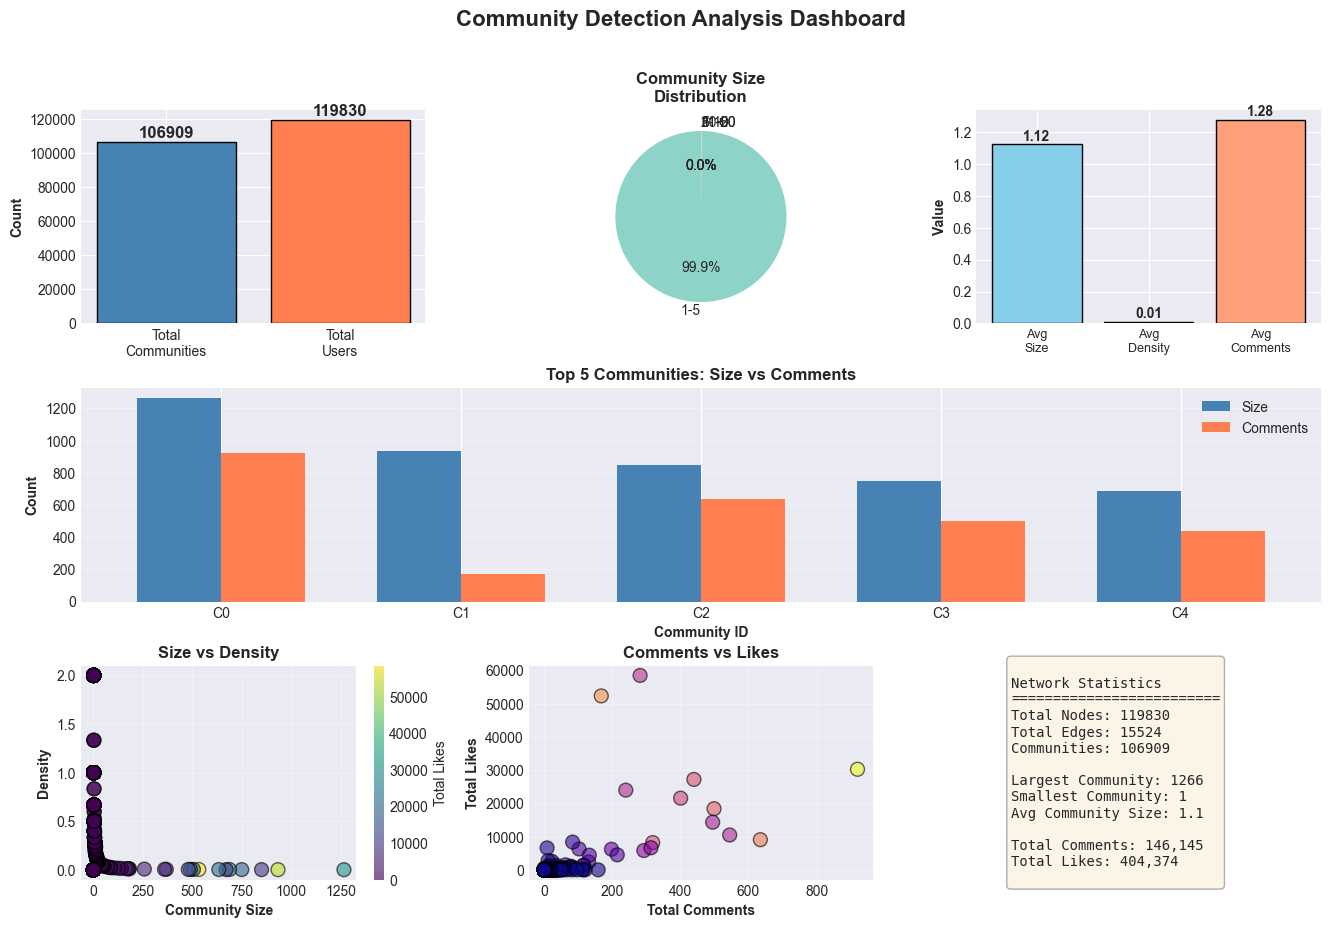

✓ Saved: viz_summary_dashboard.png

ALL VISUALIZATIONS COMPLETED!


In [117]:
# Visualization 6: Summary Dashboard
fig = plt.figure(figsize=(16, 10))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# Title
fig.suptitle('Community Detection Analysis Dashboard', fontsize=16, fontweight='bold', y=0.98)

# 1. Total communities and users
ax1 = fig.add_subplot(gs[0, 0])
stats = [len(communities_df), len(user_to_community)]
bars1 = ax1.bar(['Total\nCommunities', 'Total\nUsers'], stats, color=['steelblue', 'coral'], edgecolor='black')
ax1.set_ylabel('Count', fontweight='bold')
for i, v in enumerate(stats):
    ax1.text(i, v + max(stats)*0.02, str(v), ha='center', fontweight='bold', fontsize=12)

# 2. Community size distribution (pie chart)
ax2 = fig.add_subplot(gs[0, 1])
size_categories = pd.cut(communities_df['size'], bins=[0, 5, 10, 20, 50, float('inf')], 
                         labels=['1-5', '6-10', '11-20', '21-50', '50+'])
size_counts = size_categories.value_counts()
ax2.pie(size_counts.values, labels=size_counts.index, autopct='%1.1f%%', 
        colors=plt.cm.Set3(range(len(size_counts))), startangle=90)
ax2.set_title('Community Size\nDistribution', fontweight='bold')

# 3. Average metrics
ax3 = fig.add_subplot(gs[0, 2])
avg_metrics = {
    'Avg Size': communities_df['size'].mean(),
    'Avg Density': communities_df['density'].mean(),
    'Avg Comments': communities_df['avg_comments_per_user'].mean()
}
bars3 = ax3.bar(range(len(avg_metrics)), list(avg_metrics.values()), 
                color=['skyblue', 'lightgreen', 'lightsalmon'], edgecolor='black')
ax3.set_xticks(range(len(avg_metrics)))
ax3.set_xticklabels([k.replace(' ', '\n') for k in avg_metrics.keys()], fontsize=9)
ax3.set_ylabel('Value', fontweight='bold')
for i, (k, v) in enumerate(avg_metrics.items()):
    ax3.text(i, v + max(avg_metrics.values())*0.02, f'{v:.2f}', ha='center', fontweight='bold')

# 4. Top 5 communities by size
ax4 = fig.add_subplot(gs[1, :])
top5 = communities_df.head(5)
x = np.arange(len(top5))
width = 0.35
bars4_1 = ax4.bar(x - width/2, top5['size'], width, label='Size', color='steelblue')
bars4_2 = ax4.bar(x + width/2, top5['total_comments'], width, label='Comments', color='coral')
ax4.set_xlabel('Community ID', fontweight='bold')
ax4.set_ylabel('Count', fontweight='bold')
ax4.set_title('Top 5 Communities: Size vs Comments', fontweight='bold')
ax4.set_xticks(x)
ax4.set_xticklabels([f"C{int(cid)}" for cid in top5['community_id']])
ax4.legend()
ax4.grid(axis='y', alpha=0.3)

# 5. Density vs Size scatter
ax5 = fig.add_subplot(gs[2, 0])
scatter = ax5.scatter(communities_df['size'], communities_df['density'], 
                      c=communities_df['total_likes'], cmap='viridis', 
                      s=100, alpha=0.6, edgecolor='black')
ax5.set_xlabel('Community Size', fontweight='bold')
ax5.set_ylabel('Density', fontweight='bold')
ax5.set_title('Size vs Density', fontweight='bold')
ax5.grid(alpha=0.3)
plt.colorbar(scatter, ax=ax5, label='Total Likes')

# 6. Comments vs Likes
ax6 = fig.add_subplot(gs[2, 1])
ax6.scatter(communities_df['total_comments'], communities_df['total_likes'], 
            c=communities_df['size'], cmap='plasma', s=100, alpha=0.6, edgecolor='black')
ax6.set_xlabel('Total Comments', fontweight='bold')
ax6.set_ylabel('Total Likes', fontweight='bold')
ax6.set_title('Comments vs Likes', fontweight='bold')
ax6.grid(alpha=0.3)

# 7. Network statistics text
ax7 = fig.add_subplot(gs[2, 2])
ax7.axis('off')
network_stats = f"""
Network Statistics
{'='*25}
Total Nodes: {network.number_of_nodes()}
Total Edges: {network.number_of_edges()}
Communities: {len(communities_df)}

Largest Community: {communities_df['size'].max()}
Smallest Community: {communities_df['size'].min()}
Avg Community Size: {communities_df['size'].mean():.1f}

Total Comments: {communities_df['total_comments'].sum():,}
Total Likes: {communities_df['total_likes'].sum():,}
"""
ax7.text(0.1, 0.5, network_stats, fontsize=10, verticalalignment='center', 
         family='monospace', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

plt.savefig('viz_summary_dashboard.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved: viz_summary_dashboard.png")
print("\n" + "="*70)
print("ALL VISUALIZATIONS COMPLETED!")
print("="*70)

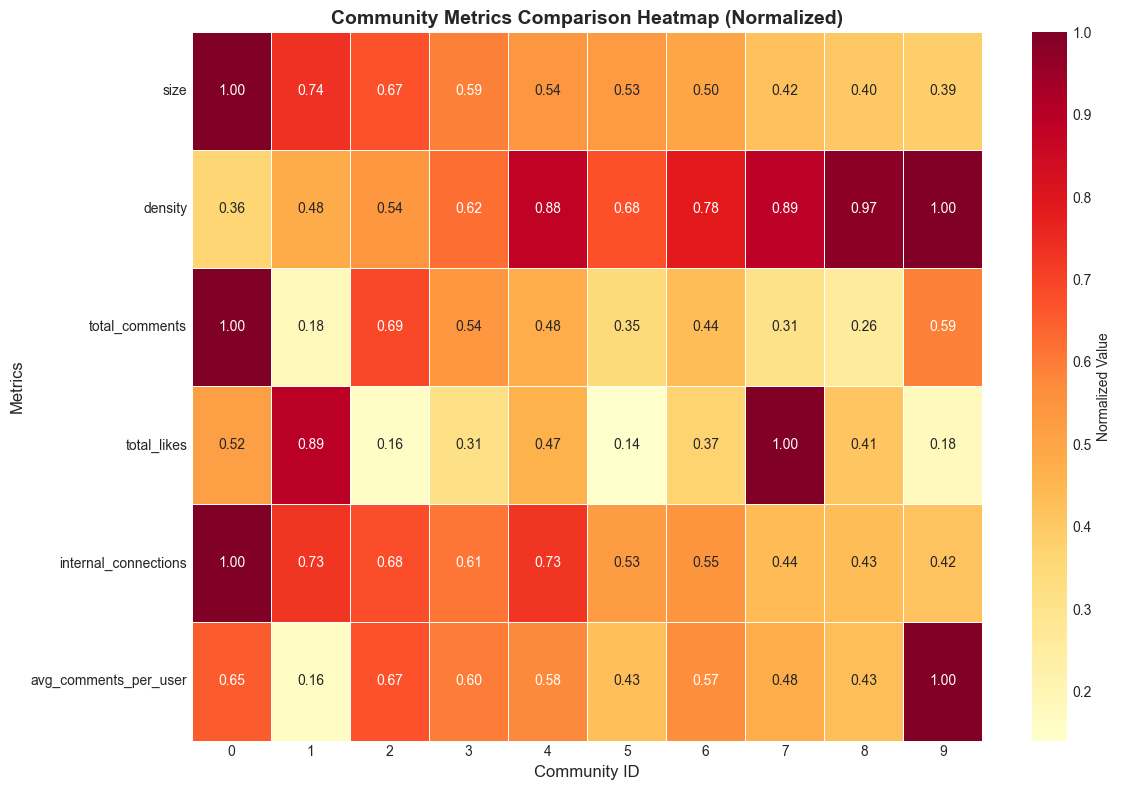

✓ Saved: viz_community_heatmap.png


In [118]:
# Visualization 5: Community Comparison Heatmap
fig, ax = plt.subplots(figsize=(12, 8))

# Prepare data for heatmap (normalize for better visualization)
heatmap_data = communities_df.head(10)[['community_id', 'size', 'density', 'total_comments', 
                                         'total_likes', 'internal_connections', 'avg_comments_per_user']].copy()

# Normalize each metric to 0-1 scale for comparison
for col in ['size', 'density', 'total_comments', 'total_likes', 'internal_connections', 'avg_comments_per_user']:
    max_val = heatmap_data[col].max()
    if max_val > 0:
        heatmap_data[col] = heatmap_data[col] / max_val

# Set community_id as index
heatmap_data = heatmap_data.set_index('community_id')

# Create heatmap
sns.heatmap(heatmap_data.T, annot=True, fmt='.2f', cmap='YlOrRd', 
            cbar_kws={'label': 'Normalized Value'}, ax=ax, linewidths=0.5)

ax.set_title('Community Metrics Comparison Heatmap (Normalized)', fontsize=14, fontweight='bold')
ax.set_xlabel('Community ID', fontsize=12)
ax.set_ylabel('Metrics', fontsize=12)

plt.tight_layout()
plt.savefig('viz_community_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved: viz_community_heatmap.png")

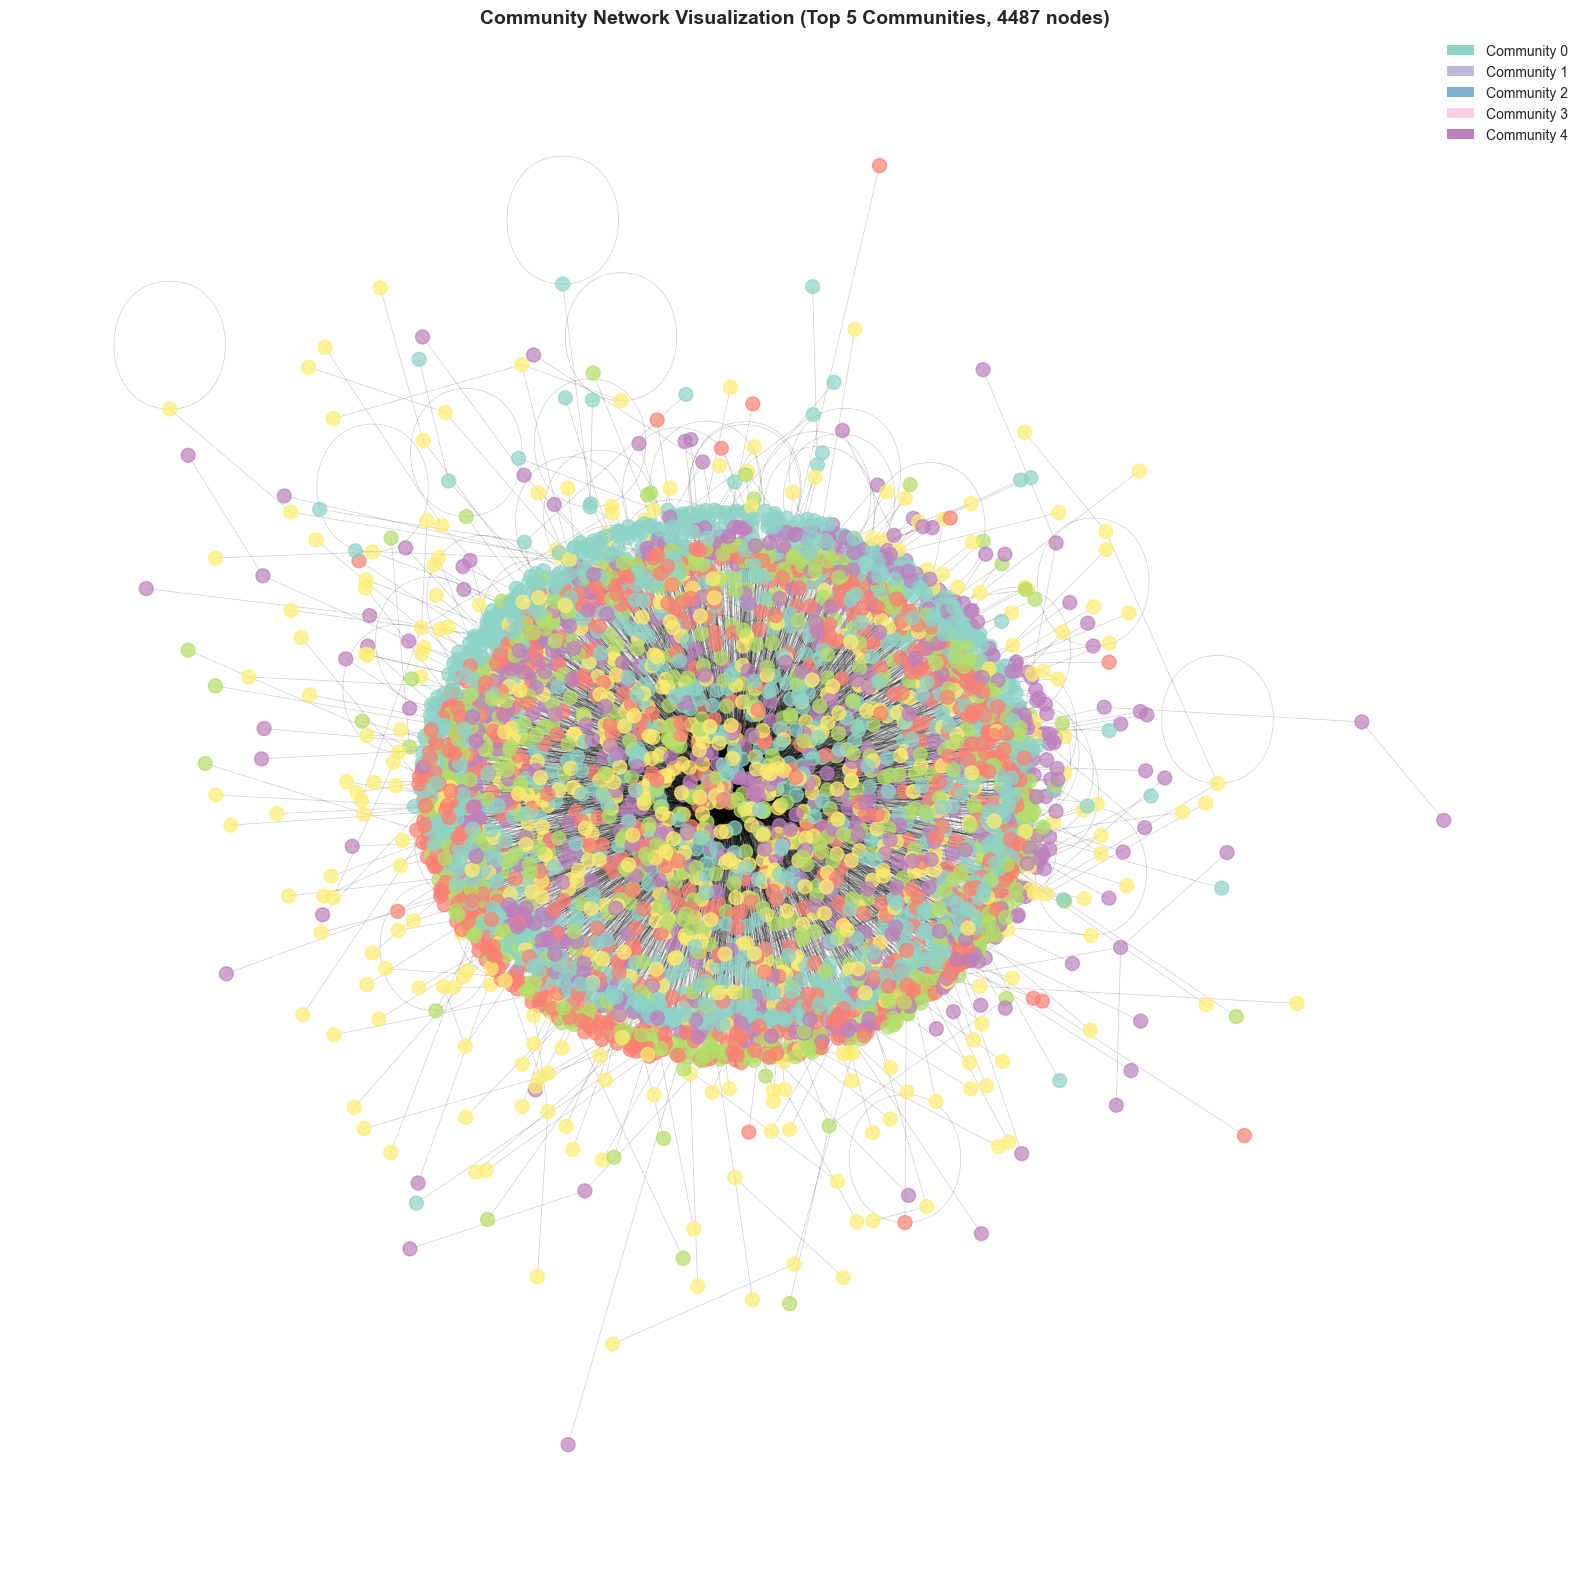

✓ Saved: viz_network_graph.png


In [119]:
# Visualization 4: Network Graph Visualization (using spring layout)
fig, ax = plt.subplots(figsize=(16, 16))

# Get undirected graph for visualization
G_vis = network.to_undirected()

# Limit to top communities for cleaner visualization
top_community_ids = communities_df.head(5)['community_id'].tolist()
nodes_to_show = [node for node, comm in user_to_community.items() if comm in top_community_ids]
G_subgraph = G_vis.subgraph(nodes_to_show)

# Generate layout
pos = nx.spring_layout(G_subgraph, k=0.5, iterations=50, seed=42)

# Color nodes by community
node_colors = [user_to_community[node] for node in G_subgraph.nodes()]

# Draw network
nx.draw_networkx_nodes(G_subgraph, pos, 
                       node_color=node_colors,
                       node_size=100,
                       cmap=plt.cm.Set3,
                       alpha=0.7,
                       ax=ax)

nx.draw_networkx_edges(G_subgraph, pos, 
                       alpha=0.2,
                       width=0.5,
                       ax=ax)

ax.set_title(f'Community Network Visualization (Top 5 Communities, {len(G_subgraph.nodes())} nodes)', 
             fontsize=14, fontweight='bold')
ax.axis('off')

# Add legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=plt.cm.Set3(i/5), label=f'Community {cid}') 
                   for i, cid in enumerate(top_community_ids)]
ax.legend(handles=legend_elements, loc='upper right', fontsize=10)

plt.tight_layout()
plt.savefig('viz_network_graph.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved: viz_network_graph.png")

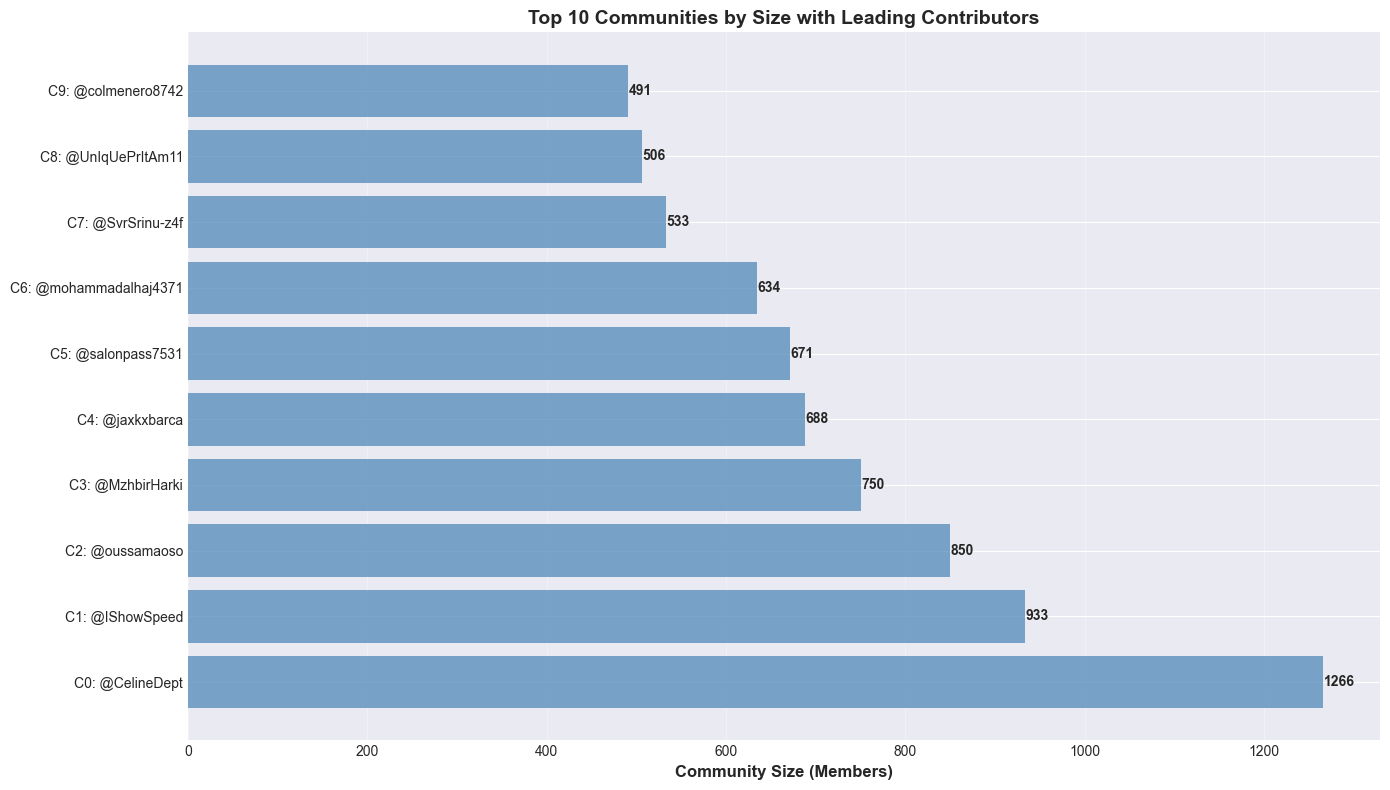

✓ Saved: viz_top_communities.png


In [120]:
# Visualization 3: Top Contributors in Top Communities
fig, ax = plt.subplots(figsize=(14, 8))

# Get top 10 communities by size
top_communities = communities_df.head(10)

y_pos = np.arange(len(top_communities))
bars = ax.barh(y_pos, top_communities['size'], color='steelblue', alpha=0.7)

# Add labels with top contributor names
ax.set_yticks(y_pos)
labels = [f"C{row['community_id']}: {row['top_contributor'][:30]}..." 
          if len(row['top_contributor']) > 30 else f"C{row['community_id']}: {row['top_contributor']}"
          for _, row in top_communities.iterrows()]
ax.set_yticklabels(labels)

ax.set_xlabel('Community Size (Members)', fontsize=12, fontweight='bold')
ax.set_title('Top 10 Communities by Size with Leading Contributors', fontsize=14, fontweight='bold')
ax.grid(axis='x', alpha=0.3)

# Add value labels on bars
for i, (idx, row) in enumerate(top_communities.iterrows()):
    ax.text(row['size'] + 0.5, i, str(int(row['size'])), 
            va='center', fontweight='bold')

plt.tight_layout()
plt.savefig('viz_top_communities.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved: viz_top_communities.png")

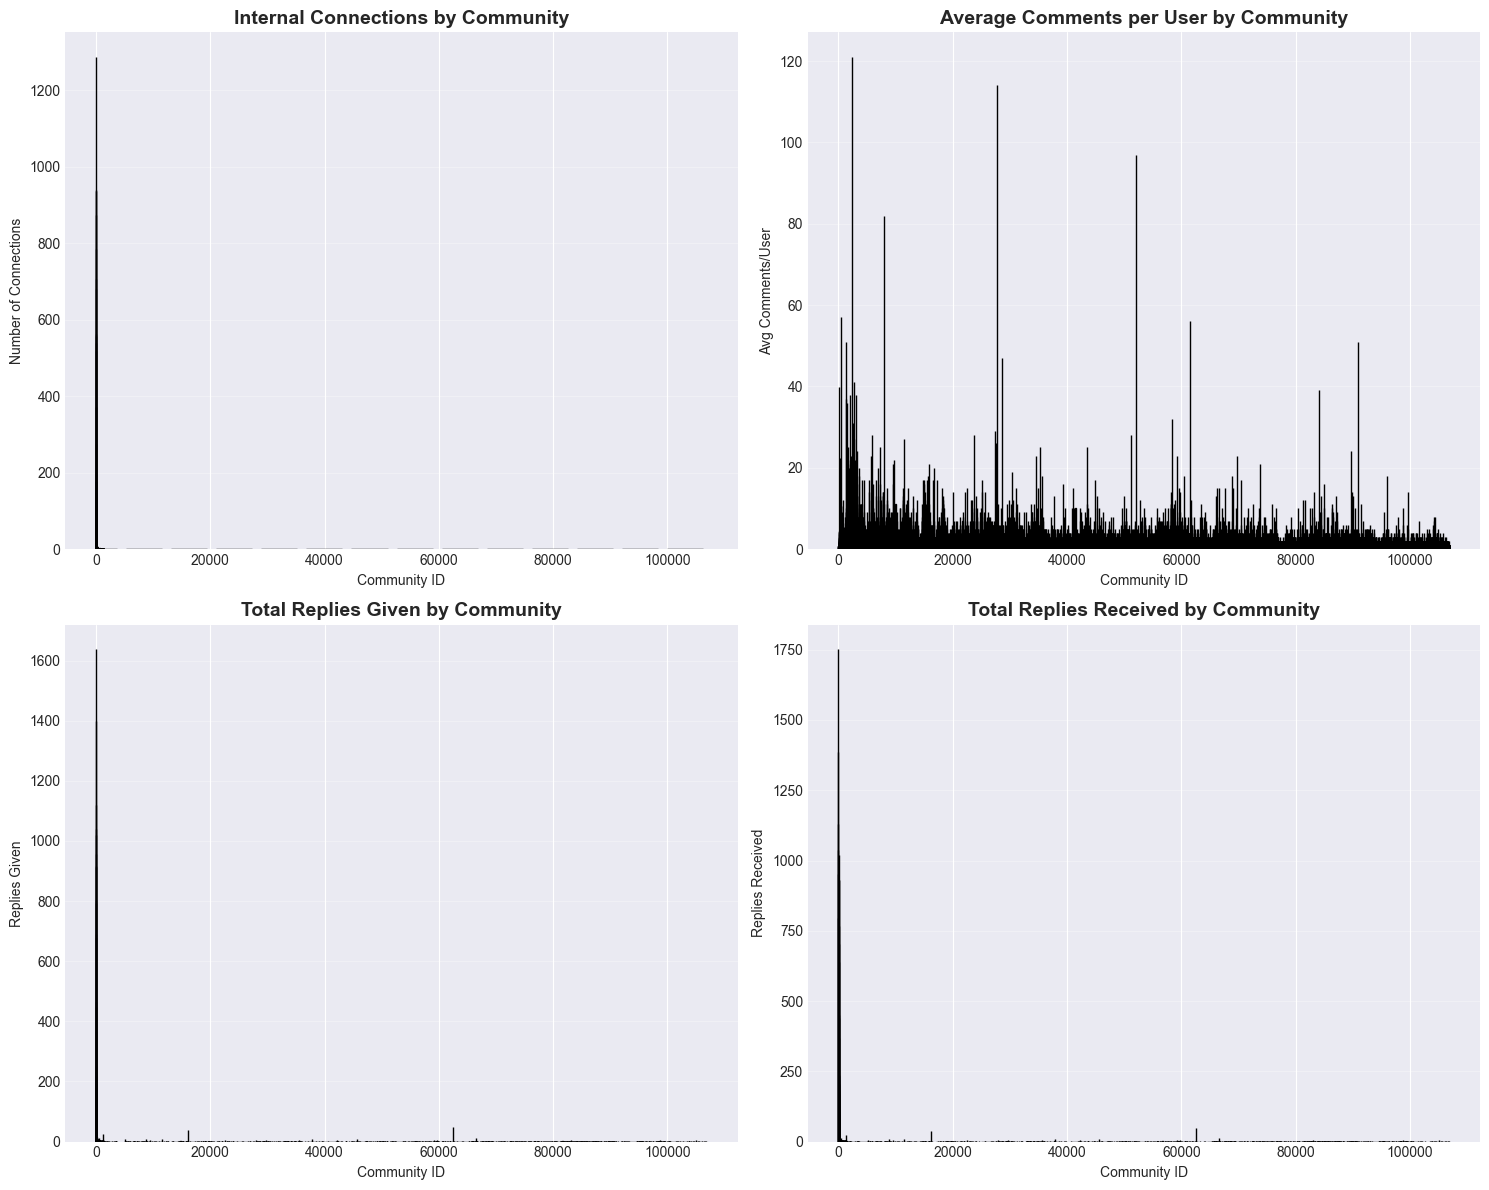

✓ Saved: viz_community_engagement.png


In [121]:
# Visualization 2: Community Engagement Metrics
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Internal connections (edges within community)
axes[0, 0].bar(communities_df['community_id'], communities_df['internal_connections'], color='skyblue', edgecolor='black')
axes[0, 0].set_title('Internal Connections by Community', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Community ID')
axes[0, 0].set_ylabel('Number of Connections')
axes[0, 0].grid(axis='y', alpha=0.3)

# Average comments per user
axes[0, 1].bar(communities_df['community_id'], communities_df['avg_comments_per_user'], color='plum', edgecolor='black')
axes[0, 1].set_title('Average Comments per User by Community', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Community ID')
axes[0, 1].set_ylabel('Avg Comments/User')
axes[0, 1].grid(axis='y', alpha=0.3)

# Total replies given
axes[1, 0].bar(communities_df['community_id'], communities_df['total_replies_given'], color='khaki', edgecolor='black')
axes[1, 0].set_title('Total Replies Given by Community', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Community ID')
axes[1, 0].set_ylabel('Replies Given')
axes[1, 0].grid(axis='y', alpha=0.3)

# Total replies received
axes[1, 1].bar(communities_df['community_id'], communities_df['total_replies_received'], color='lightcyan', edgecolor='black')
axes[1, 1].set_title('Total Replies Received by Community', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Community ID')
axes[1, 1].set_ylabel('Replies Received')
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('viz_community_engagement.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved: viz_community_engagement.png")

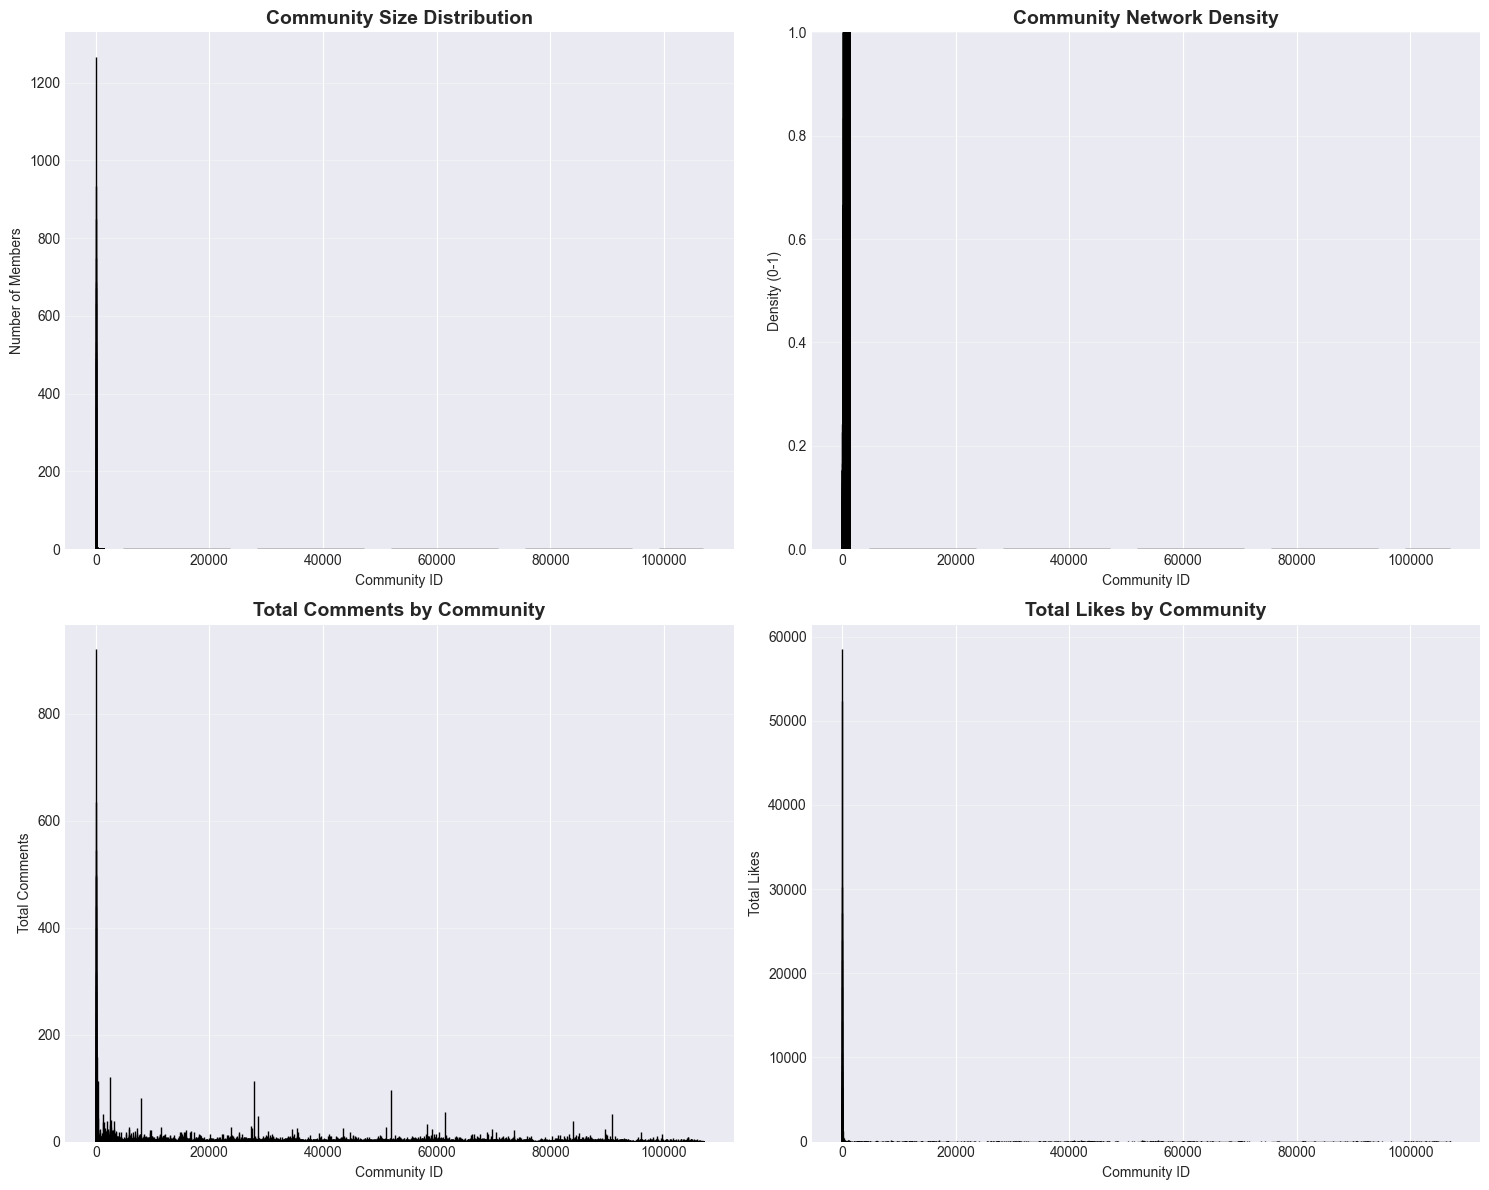

✓ Saved: viz_community_distribution.png


In [122]:
# Visualization 1: Community Size Distribution
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Community size bar chart
axes[0, 0].bar(communities_df['community_id'], communities_df['size'], color='steelblue', edgecolor='black')
axes[0, 0].set_title('Community Size Distribution', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Community ID')
axes[0, 0].set_ylabel('Number of Members')
axes[0, 0].grid(axis='y', alpha=0.3)

# Community density
axes[0, 1].bar(communities_df['community_id'], communities_df['density'], color='coral', edgecolor='black')
axes[0, 1].set_title('Community Network Density', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Community ID')
axes[0, 1].set_ylabel('Density (0-1)')
axes[0, 1].set_ylim([0, 1])
axes[0, 1].grid(axis='y', alpha=0.3)

# Total comments by community
axes[1, 0].bar(communities_df['community_id'], communities_df['total_comments'], color='lightgreen', edgecolor='black')
axes[1, 0].set_title('Total Comments by Community', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Community ID')
axes[1, 0].set_ylabel('Total Comments')
axes[1, 0].grid(axis='y', alpha=0.3)

# Total likes by community
axes[1, 1].bar(communities_df['community_id'], communities_df['total_likes'], color='lightsalmon', edgecolor='black')
axes[1, 1].set_title('Total Likes by Community', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Community ID')
axes[1, 1].set_ylabel('Total Likes')
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('viz_community_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved: viz_community_distribution.png")